In [1]:
import pandas as pd
from datetime import datetime
from razdel import tokenize
import emoji
import string
import re
import pymorphy2
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from collections import defaultdict
import numpy as np
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv("../data.csv")

In [3]:
df

,Компания,Итоговый рейтинг,Количество оценок,Имена авторов,Ранг автора,Дата отзыва,Рейтинг отзыва,Текст отзыва
0,ЛСР,4.3,294.0,Ирина Мандрик,Знаток города 3 уровня,1 апреля,5.0,Я давно мечтала купить квартиру в Санкт-Петерб...
1,ЛСР,4.3,294.0,Алия Сазонова,Знаток города 8 уровня,6 декабря 2019,5.0,"Продажа квартир, паркинг мест напрямую от вед..."
2,ЛСР,4.3,294.0,Дарья Лапкина,Знаток города 2 уровня,9 мая,2.0,"Купили квартиру в Цивилизации на Неве,с отделк..."
3,ЛСР,4.3,294.0,Иван М.,Знаток города 3 уровня,29 февраля 2024,1.0,"Квартира в жк Морская набережная, 1-я очередь...."
4,ЛСР,4.3,294.0,Оксана,Знаток города 5 уровня,8 июля,5.0,Приобрели удаленно квартиру в ЖК Пейзажный ква...
...,...,...,...,...,...,...,...,...
2185,Пятёрочка,4.1,968.0,Анна Гурьянова,Знаток города 9 уровня,2 сентября 2024,4.0,Классный продуктовый магазинчик и приятное обс...
2186,Пятёрочка,4.1,968.0,Валентин Граблин,Знаток города 16 уровня,5 ноября 2024,4.0,Пригодный продуктовый магазин и сервис обслужи...
2187,Пятёрочка,4.1,968.0,Катя Щ.,Знаток города 12 уровня,6 мая 2022,3.0,"Ну так себе. Цены нормальные, по началу как то..."
2188,Пятёрочка,4.1,968.0,Савелий Жухарев,Знаток города 10 уровня,14 июня 2021,2.0,В целом нормальная пятёрочка. Есть из чего выб...


In [4]:
df['Рейтинг отзыва'] = pd.to_numeric(df['Рейтинг отзыва'], errors='coerce')  # преобразует нечисловые значения в NaN
df['Итоговый рейтинг'] = pd.to_numeric(df['Итоговый рейтинг'], errors='coerce')
df['Количество оценок'] = pd.to_numeric(df['Количество оценок'], errors='coerce')

In [5]:
month_translation = {
    'января': 'January',
    'февраля': 'February',
    'марта': 'March',
    'апреля': 'April',
    'мая': 'May',
    'июня': 'June',
    'июля': 'July',
    'августа': 'August',
    'сентября': 'September',
    'октября': 'October',
    'ноября': 'November',
    'декабря': 'December'
}

def parse_date_russian(date_str):
    parts = date_str.split()
    day = parts[0]
    month_ru = parts[1]
    
    # Заменяем русское название месяца на английское
    month_en = month_translation.get(month_ru, month_ru)
    
    # Если есть год, берем его, иначе — текущий
    year = parts[2] if len(parts) > 2 else str(datetime.now().year)
    
    date_formatted = f"{day} {month_en} {year}"
    return datetime.strptime(date_formatted, "%d %B %Y").date()

df['Дата отзыва'] = df['Дата отзыва'].apply(parse_date_russian)

In [6]:
df.describe()

,Итоговый рейтинг,Количество оценок,Рейтинг отзыва
count,1684.000000,2140.000000,2190.000000
mean,4.385748,10649.083178,4.034247
std,0.394163,42805.508370,1.515028
min,2.800000,15.000000,1.000000
25%,4.200000,281.000000,3.000000
50%,4.400000,659.000000,5.000000
75%,4.700000,1235.000000,5.000000
max,4.900000,222194.000000,5.000000


In [7]:
# Обработка текста
# Приведение к нижнему регистру
df["tokens"] = df['Текст отзыва'].str.lower()

# Удаление эмоджи
df["tokens"] = df["tokens"].apply(lambda s: emoji.replace_emoji(s, ''))

# Токенизация
def get_tokens(sentence):
  return [_.text.strip() for _ in tokenize(sentence)]

df['tokens'] = df.tokens.apply(get_tokens)

# Удалние пунктуации
df["tokens"] = df.tokens.apply(lambda row: [token for token in row if token not in string.punctuation + string.digits + '...'+'—'+'»'+'«'+"–" + '**' + '⁃' + '=)'+'•'+'-'])
df["tokens"] = df["tokens"].apply(lambda row: [token for token in row if not re.match(r'^-+$', token)])

# Удаление английских слов
df["tokens"] = df["tokens"].apply(lambda row: [token for token in row if token == "it" or not re.search(r"[a-zA-Z]+", token)])

In [8]:
# Лемматизация
def pymorphy2_311_hotfix():
  from inspect import getfullargspec
  from pymorphy2.units.base import BaseAnalyzerUnit

  def _get_param_names_311(klass):
    if klass.__init__ is object.__init__:
      return []
    args = getfullargspec(klass.__init__).args
    return sorted(args[1:])

  setattr(BaseAnalyzerUnit, '_get_param_names', _get_param_names_311)

pymorphy2_311_hotfix()
analyzer = pymorphy2.MorphAnalyzer()

df["tokens"] = tqdm(df.tokens.apply(lambda row: [analyzer.parse(token)[0].normal_form for token in row if token]))

100%|█████████████████████████████████████████████████████████████████████████| 2190/2190 [00:00<00:00, 2189636.65it/s]


In [9]:
df.head()

,Компания,Итоговый рейтинг,Количество оценок,Имена авторов,Ранг автора,Дата отзыва,Рейтинг отзыва,Текст отзыва,tokens
0,ЛСР,4.3,294.0,Ирина Мандрик,Знаток города 3 уровня,2025-04-01,5.0,Я давно мечтала купить квартиру в Санкт-Петерб...,"[я, давно, мечтать, купить, квартира, в, санкт..."
1,ЛСР,4.3,294.0,Алия Сазонова,Знаток города 8 уровня,2019-12-06,5.0,"Продажа квартир, паркинг мест напрямую от вед...","[продажа, квартира, паркинг, место, напрямую, ..."
2,ЛСР,4.3,294.0,Дарья Лапкина,Знаток города 2 уровня,2025-05-09,2.0,"Купили квартиру в Цивилизации на Неве,с отделк...","[купить, квартира, в, цивилизация, на, нева, с..."
3,ЛСР,4.3,294.0,Иван М.,Знаток города 3 уровня,2024-02-29,1.0,"Квартира в жк Морская набережная, 1-я очередь....","[квартира, в, жк, морской, набережная, 1-й, оч..."
4,ЛСР,4.3,294.0,Оксана,Знаток города 5 уровня,2025-07-08,5.0,Приобрели удаленно квартиру в ЖК Пейзажный ква...,"[приобрести, удалённый, квартира, в, жк, пейза..."


In [10]:
# Удаление стоп слов
nltk.download("stopwords")
nltk.download("punkt")

additional_stops=["это", "который", "наш", "мочь", "год","такой", "мы", "свой", "один", "другой", "человек", "всё", "все", "весь", "очень", "каждый", "день", "её", "ваш", "ваше", "день", "самый", "ещё","также", "нужно","например", "вещь", "хороший", 'новый', "спасибо", 'твой', 'любой','что-то','че','какой-то','какой-то', 'привет', 'час', 'месяц','неделя','сегодня', '…', '!!!']
om_stops=['сообщество', 'ом', 'антон','назаров']

stops = list(string.ascii_lowercase) + list('абвгдеёжзийклмнопрстуфхцчшщъыьэюя') + stopwords.words("russian") + om_stops + additional_stops

df["tokens"] = df.tokens.apply(lambda row: [token for token in row if token not in stops])

df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\s-bek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\s-bek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Компания,Итоговый рейтинг,Количество оценок,Имена авторов,Ранг автора,Дата отзыва,Рейтинг отзыва,Текст отзыва,tokens
0,ЛСР,4.3,294.0,Ирина Мандрик,Знаток города 3 уровня,2025-04-01,5.0,Я давно мечтала купить квартиру в Санкт-Петерб...,"[давно, мечтать, купить, квартира, санкт-петер..."
1,ЛСР,4.3,294.0,Алия Сазонова,Знаток города 8 уровня,2019-12-06,5.0,"Продажа квартир, паркинг мест напрямую от вед...","[продажа, квартира, паркинг, место, напрямую, ..."
2,ЛСР,4.3,294.0,Дарья Лапкина,Знаток города 2 уровня,2025-05-09,2.0,"Купили квартиру в Цивилизации на Неве,с отделк...","[купить, квартира, цивилизация, нева, отделка,..."
3,ЛСР,4.3,294.0,Иван М.,Знаток города 3 уровня,2024-02-29,1.0,"Квартира в жк Морская набережная, 1-я очередь....","[квартира, жк, морской, набережная, 1-й, очере..."
4,ЛСР,4.3,294.0,Оксана,Знаток города 5 уровня,2025-07-08,5.0,Приобрели удаленно квартиру в ЖК Пейзажный ква...,"[приобрести, удалённый, квартира, жк, пейзажны..."


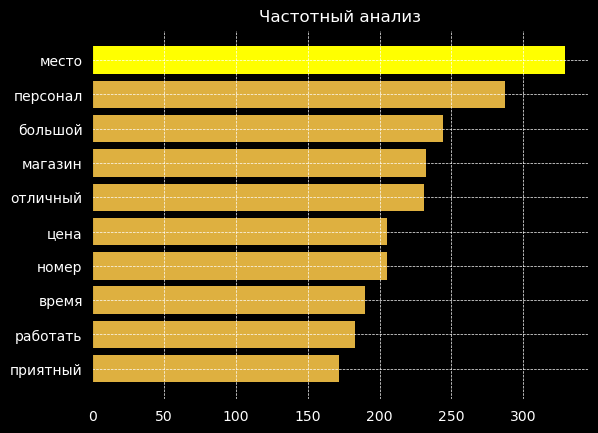

In [11]:
# Частотный анализ
all_words = []
for doc in df.tokens.tolist():
  all_words.extend(doc)

# Частотный анализ
res = pd.DataFrame(all_words, columns=["terms"])
vis = pd.DataFrame(res.terms.value_counts()).reset_index()
vis.columns = ['terms', 'counts']
vis=vis.sort_values(by="counts")[-10:]
colors = ["#DEB040" for _ in range(9)]+["yellow"]
plt.figure(facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')
plt.tick_params(labelcolor='white')
plt.barh(y=vis.terms, width=vis.counts, color=colors)
plt.grid(color='white', linestyle='--', linewidth=0.5)
plt.title("Частотный анализ", color='white')
plt.show()

In [12]:
new_df = df[['tokens', 'Рейтинг отзыва']].copy()

In [13]:
new_df

,tokens,Рейтинг отзыва
0,"[давно, мечтать, купить, квартира, санкт-петер...",5.0
1,"[продажа, квартира, паркинг, место, напрямую, ...",5.0
2,"[купить, квартира, цивилизация, нева, отделка,...",2.0
3,"[квартира, жк, морской, набережная, 1-й, очере...",1.0
4,"[приобрести, удалённый, квартира, жк, пейзажны...",5.0
...,...,...
2185,"[классный, продуктовый, магазинчик, приятный, ...",4.0
2186,"[пригодный, продуктовый, магазин, сервис, обсл...",4.0
2187,"[цена, нормальный, начало, прийти, долго, найт...",3.0
2188,"[целое, нормальный, пятёрочка, выбрать, подбор...",2.0


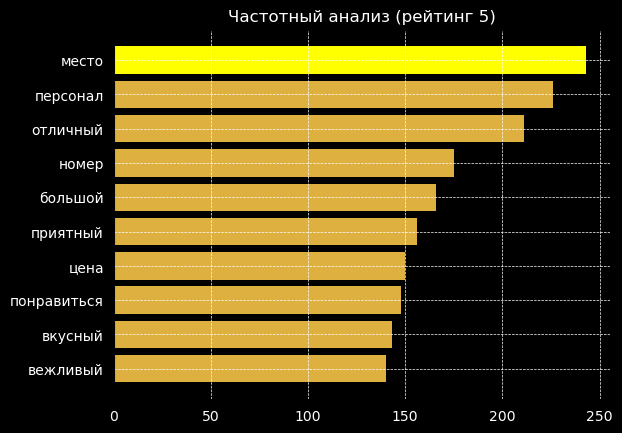

In [14]:
# Разделение по рейтингу
df5 = new_df[new_df['Рейтинг отзыва'] == 5].copy()

# Частотный анализ
all_words = []
for doc in df5.tokens.tolist():
  all_words.extend(doc)

res = pd.DataFrame(all_words, columns=["terms"])
vis = pd.DataFrame(res.terms.value_counts()).reset_index()
vis.columns = ['terms', 'counts']
vis=vis.sort_values(by="counts")[-10:]
colors = ["#DEB040" for _ in range(9)]+["yellow"]
plt.figure(facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')
plt.tick_params(labelcolor='white')
plt.barh(y=vis.terms, width=vis.counts, color=colors)
plt.grid(color='white', linestyle='--', linewidth=0.5)
plt.title("Частотный анализ (рейтинг 5)", color='white')
plt.show()

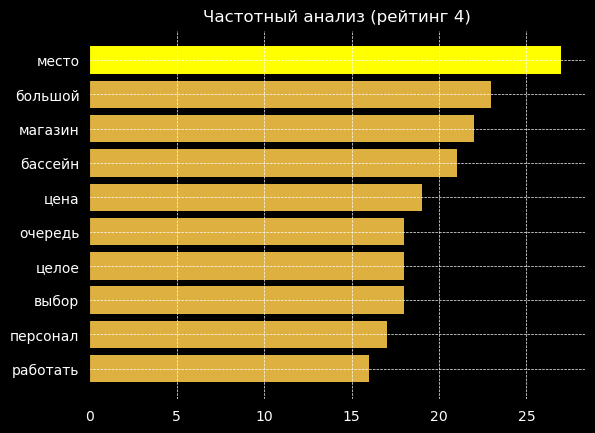

In [15]:
# Разделение по рейтингу
df4 = new_df[new_df['Рейтинг отзыва'] == 4].copy()

# Частотный анализ
all_words = []
for doc in df4.tokens.tolist():
  all_words.extend(doc)

res = pd.DataFrame(all_words, columns=["terms"])
vis = pd.DataFrame(res.terms.value_counts()).reset_index()
vis.columns = ['terms', 'counts']
vis=vis.sort_values(by="counts")[-10:]
colors = ["#DEB040" for _ in range(9)]+["yellow"]
plt.figure(facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')
plt.tick_params(labelcolor='white')
plt.barh(y=vis.terms, width=vis.counts, color=colors)
plt.grid(color='white', linestyle='--', linewidth=0.5)
plt.title("Частотный анализ (рейтинг 4)", color='white')
plt.show()

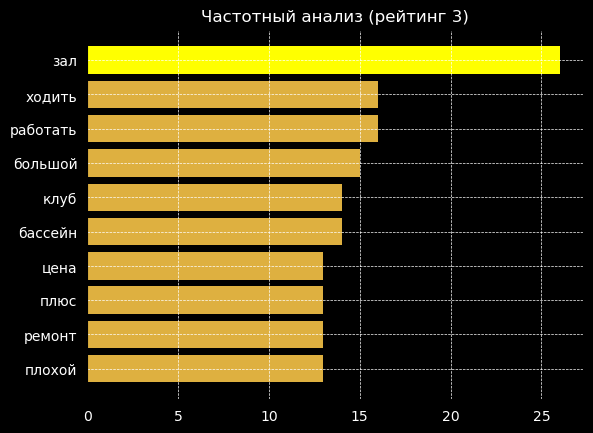

In [16]:
# Разделение по рейтингу
df3 = new_df[new_df['Рейтинг отзыва'] == 3].copy()

# Частотный анализ
all_words = []
for doc in df3.tokens.tolist():
  all_words.extend(doc)

res = pd.DataFrame(all_words, columns=["terms"])
vis = pd.DataFrame(res.terms.value_counts()).reset_index()
vis.columns = ['terms', 'counts']
vis=vis.sort_values(by="counts")[-10:]
colors = ["#DEB040" for _ in range(9)]+["yellow"]
plt.figure(facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')
plt.tick_params(labelcolor='white')
plt.barh(y=vis.terms, width=vis.counts, color=colors)
plt.grid(color='white', linestyle='--', linewidth=0.5)
plt.title("Частотный анализ (рейтинг 3)", color='white')
plt.show()

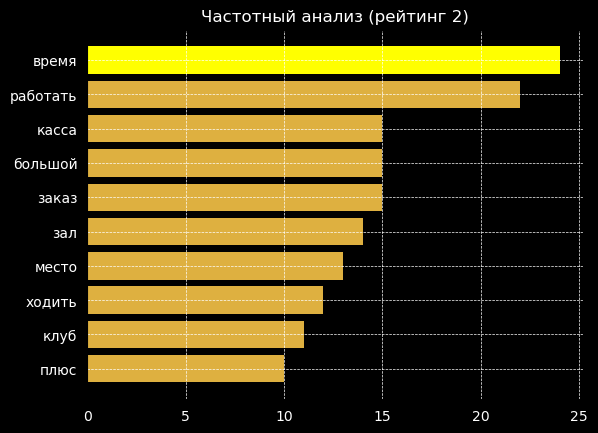

In [17]:
# Разделение по рейтингу
df2 = new_df[new_df['Рейтинг отзыва'] == 2].copy()

# Частотный анализ
all_words = []
for doc in df2.tokens.tolist():
  all_words.extend(doc)

res = pd.DataFrame(all_words, columns=["terms"])
vis = pd.DataFrame(res.terms.value_counts()).reset_index()
vis.columns = ['terms', 'counts']
vis=vis.sort_values(by="counts")[-10:]
colors = ["#DEB040" for _ in range(9)]+["yellow"]
plt.figure(facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')
plt.tick_params(labelcolor='white')
plt.barh(y=vis.terms, width=vis.counts, color=colors)
plt.grid(color='white', linestyle='--', linewidth=0.5)
plt.title("Частотный анализ (рейтинг 2)", color='white')
plt.show()

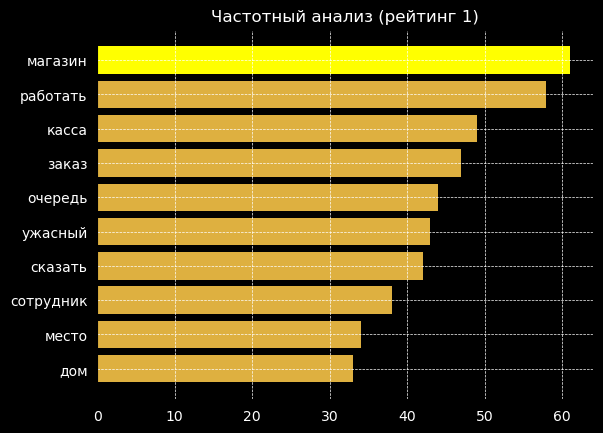

In [18]:
df1 = new_df[new_df['Рейтинг отзыва'] == 1].copy()

# Частотный анализ
all_words = []
for doc in df1.tokens.tolist():
  all_words.extend(doc)

res = pd.DataFrame(all_words, columns=["terms"])
vis = pd.DataFrame(res.terms.value_counts()).reset_index()
vis.columns = ['terms', 'counts']
vis=vis.sort_values(by="counts")[-10:]
colors = ["#DEB040" for _ in range(9)]+["yellow"]
plt.figure(facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')
plt.tick_params(labelcolor='white')
plt.barh(y=vis.terms, width=vis.counts, color=colors)
plt.grid(color='white', linestyle='--', linewidth=0.5)
plt.title("Частотный анализ (рейтинг 1)", color='white')
plt.show()

In [19]:
print(len(df1))
print(len(df2))
print(len(df3))
print(len(df4))
print(len(df5))

334
110
142
165
1439


In [20]:
# Классификация на 5 классов
class SentenceTonalClassifier_5:
    def __init__(self, alpha=1.0):
        self.alpha = alpha  # Сглаживание Лапласа
        self.prior = None   # P(Класс)
        self.likelihood = None  # P(Слово|Класс)
        self.classes = None  # Доступные классы

    def fit(self, tokenized_sentences, labels):
        """Обучение модели на токенизированных предложениях."""
        self.classes = np.unique(labels)
        n_samples = len(tokenized_sentences)

        # Вычисляем P(Класс)
        self.prior = defaultdict(float)
        for c in self.classes:
            self.prior[c] = np.sum(labels == c) / n_samples

        # Подсчитываем частоту слов в каждом классе
        word_counts = defaultdict(lambda: defaultdict(int))
        vocab = set()
        for sentence, label in zip(tokenized_sentences, labels):
            for word in sentence:
                word_counts[label][word] += 1
                vocab.add(word)
        vocab_size = len(vocab)

        # Вычисляем P(Слово|Класс) со сглаживанием
        self.likelihood = defaultdict(dict)
        for c in self.classes:
            total_words_in_class = sum(word_counts[c].values())
            for word in vocab:
                count = word_counts[c].get(word, 0)
                self.likelihood[c][word] = (count + self.alpha) / (total_words_in_class + self.alpha * vocab_size)

    def predict_sentence_tonality(self, tokenized_sentence):
        """Предсказание тональности предложения."""
        if not self.prior or not self.likelihood:
            raise ValueError("Модель не обучена!")

        # Для каждого класса считаем совокупную вероятность
        class_probs = defaultdict(float)
        for c in self.classes:
            # Начинаем с априорной вероятности класса
            class_probs[c] = np.log(self.prior[c])
            for word in tokenized_sentence:
                # Если слова нет в словаре - сглаживание
                word_prob = self.likelihood[c].get(word, self.alpha / (sum(self.prior.values()) + self.alpha * len(self.likelihood[c])))
                class_probs[c] += np.log(word_prob)

        # Нормализация (преобразуем логарифмы обратно в вероятности)
        probs = {c: np.exp(class_probs[c]) for c in class_probs}
        sum_probs = sum(probs.values())
        if sum_probs > 0:
            for c in probs:
                probs[c] /= sum_probs

        return probs

    def get_tonality_name(self, class_id):
        tonality_map = {
            1: "негативный",
            2: "умеренно негативный",
            3: "нейтральный",
            4: "умеренно позитивный",
            5: "позитивный"
        }
        return tonality_map.get(class_id, "неизвестный")

In [21]:
# Пермешивание строк
new_df = new_df.sample(frac=1, random_state=42)
print(len(new_df))

2190


In [23]:
X_train, y_train = new_df["tokens"][:2000].tolist(), new_df["Рейтинг отзыва"][:2000].tolist()
print(len(X_train))
print(len(y_train))

print()

X_test, y_test = new_df["tokens"][2000:].tolist(), new_df["Рейтинг отзыва"][2000:].tolist()
print(len(X_test))
print(len(y_test))

2000
2000

190
190


In [24]:
model = SentenceTonalClassifier_5(alpha=1.0)
model.fit(X_train, y_train)

In [25]:
y_pred = []

for sentence in X_test:
    probs = model.predict_sentence_tonality(sentence)
    best_class = max(probs, key=probs.get)
    tonality_name = model.get_tonality_name(best_class)

    y_pred.append(best_class)
    
    print(f"\nПредложение: {' '.join(sentence)}")
    print(f"Тональность: {tonality_name} (класс {best_class})")
    print("Распределение вероятностей:")
    for c, prob in sorted(probs.items()):
        print(f"  {model.get_tonality_name(c)}: {prob:.4f}")


Предложение: ой редко кто-нибудь сидеть почта банк нравиться честно процент бешеный говорить выгодный друг банк маленький вообщий вечно названивать телефон втюхивать кредитный карта сто сказать супер выгодный звонить равно
Тональность: негативный (класс 1.0)
Распределение вероятностей:
  негативный: 0.9447
  умеренно негативный: 0.0000
  нейтральный: 0.0000
  умеренно позитивный: 0.0001
  позитивный: 0.0551

Предложение: останавливаться апарта митино период 22-24 март жить 11 этаж лифт быстрый кто-то важно номер уютный чистый большой окно отопление регулироваться необходимый посуда бутылочка вода фильтр водопроводный вода плита микроволновка чайник стиральный машина
Тональность: позитивный (класс 5.0)
Распределение вероятностей:
  негативный: 0.0000
  умеренно негативный: 0.0000
  нейтральный: 0.0000
  умеренно позитивный: 0.0000
  позитивный: 1.0000

Предложение: альфа банк оказаться нелюбимый банк первый единственный банк отзыв персональный данные продолжать звонить офис назад повто

In [26]:
# Со стоп словами
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7894736842105263

Для 3 возможных тональностей: Негативный, нейтральный, Положительный

In [27]:
# Классификация на 3 класса
class SentenceTonalClassifier_3:
    def __init__(self, alpha=1.0):
        self.alpha = alpha  # Сглаживание Лапласа
        self.prior = None   # P(Класс)
        self.likelihood = None  # P(Слово|Класс)
        self.classes = None  # Доступные классы

    def fit(self, tokenized_sentences, labels):
        """Обучение модели на токенизированных предложениях."""
        self.classes = np.unique(labels)
        n_samples = len(tokenized_sentences)

        # Вычисляем P(Класс)
        self.prior = defaultdict(float)
        for c in self.classes:
            self.prior[c] = np.sum(labels == c) / n_samples

        # Подсчитываем частоту слов в каждом классе
        word_counts = defaultdict(lambda: defaultdict(int))
        vocab = set()
        for sentence, label in zip(tokenized_sentences, labels):
            for word in sentence:
                word_counts[label][word] += 1
                vocab.add(word)
        vocab_size = len(vocab)

        # Вычисляем P(Слово|Класс) с сглаживанием
        self.likelihood = defaultdict(dict)
        for c in self.classes:
            total_words_in_class = sum(word_counts[c].values())
            for word in vocab:
                count = word_counts[c].get(word, 0)
                self.likelihood[c][word] = (count + self.alpha) / (total_words_in_class + self.alpha * vocab_size)

    def predict_sentence_tonality(self, tokenized_sentence):
        """Предсказание тональности предложения."""
        if not self.prior or not self.likelihood:
            raise ValueError("Модель не обучена!")

        # Для каждого класса считаем совокупную вероятность
        class_probs = defaultdict(float)
        for c in self.classes:
            # Начинаем с априорной вероятности класса
            class_probs[c] = np.log(self.prior[c])  # логарифм для избежания переполнения
            for word in tokenized_sentence:
                # Если слова нет в словаре - сглаживание
                word_prob = self.likelihood[c].get(word, self.alpha / (sum(self.prior.values()) + self.alpha * len(self.likelihood[c])))
                class_probs[c] += np.log(word_prob)

        # Нормализация (преобразуем логарифмы обратно в вероятности)
        probs = {c: np.exp(class_probs[c]) for c in class_probs}
        sum_probs = sum(probs.values())
        if sum_probs > 0:
            for c in probs:
                probs[c] /= sum_probs

        return probs

    def get_tonality_name(self, class_id):
        tonality_map = {
            1: "негативный",
            2: "нейтральный",
            3: "позитивный"
        }
        return tonality_map.get(class_id, "неизвестный")

In [28]:
short_class_df = new_df[['tokens', 'Рейтинг отзыва']].copy()
mapping = {1 : 1, 2 : 1, 3 : 2, 4 : 3, 5 : 3}
short_class_df["Рейтинг отзыва"] = short_class_df["Рейтинг отзыва"].map(mapping)
short_class_df.head()

,tokens,Рейтинг отзыва
289,"[встреча, вечность, сердце, петербург, 25, наз...",3
1692,"[приятный, заведение, отдохнуть, компания, дру...",3
1590,"[добрый, огромный, помощь, сотрудник, отделени...",3
383,"[отличный, место, центр, площадь, вокзал, прио...",3
1818,"[чисто, быстро, красиво, чек, брать, обязатель...",3


In [29]:
print(len(short_class_df))

2190


In [46]:
# Пермешивание строк
short_class_df = short_class_df.sample(frac=1, random_state=42)

In [30]:
X_train, y_train = short_class_df["tokens"][:2000].tolist(), short_class_df["Рейтинг отзыва"][:2000].tolist()
print(len(X_train))
print(len(y_train))

print()

X_test, y_test = short_class_df["tokens"][2000:].tolist(), short_class_df["Рейтинг отзыва"][2000:].tolist()
print(len(X_test))
print(len(y_test))

2000
2000

190
190


In [31]:
model = SentenceTonalClassifier_3(alpha=1)
model.fit(X_train, y_train)

In [32]:
y_pred = []

for sentence in X_test:
    probs = model.predict_sentence_tonality(sentence)
    best_class = max(probs, key=probs.get)
    tonality_name = model.get_tonality_name(best_class)

    y_pred.append(best_class)
    
    print(f"\nПредложение: {' '.join(sentence)}")
    print(f"Тональность: {tonality_name} (класс {best_class})")
    print("Распределение вероятностей:")
    for c, prob in sorted(probs.items()):
        print(f"  {model.get_tonality_name(c)}: {prob:.4f}")


Предложение: ой редко кто-нибудь сидеть почта банк нравиться честно процент бешеный говорить выгодный друг банк маленький вообщий вечно названивать телефон втюхивать кредитный карта сто сказать супер выгодный звонить равно
Тональность: негативный (класс 1)
Распределение вероятностей:
  негативный: 0.9297
  нейтральный: 0.0000
  позитивный: 0.0703

Предложение: останавливаться апарта митино период 22-24 март жить 11 этаж лифт быстрый кто-то важно номер уютный чистый большой окно отопление регулироваться необходимый посуда бутылочка вода фильтр водопроводный вода плита микроволновка чайник стиральный машина
Тональность: позитивный (класс 3)
Распределение вероятностей:
  негативный: 0.0000
  нейтральный: 0.0000
  позитивный: 1.0000

Предложение: альфа банк оказаться нелюбимый банк первый единственный банк отзыв персональный данные продолжать звонить офис назад повторно написать заявление уничтожение персональный данные итог заявление исполнить
Тональность: негативный (класс 1)
Распределе

In [33]:
# Со стоп словами
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8736842105263158